<a href="https://colab.research.google.com/github/Anny-tech/Machine-Learning-in-Materials-Science/blob/master/BO_AL_Basic_Implementation_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# @title This is a basic implementation of BO based Active Learning using the python based BoTorch package.

In [51]:

# @title Import Packages
from google.colab import drive
import subprocess
import sys
from typing import Tuple


'''Check which packages are already installed/ need to be installed and install
them automatically.'''

def install_package(package: str) -> None:
    """Install a package using pip."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install_packages(required_packages: dict) -> None:
    """Check and install missing packages."""
    for package, import_name in required_packages.items():
        try:
            __import__(import_name)
            print(f"{package} is already installed.")
        except ImportError:
            print(f"{package} is not installed. Installing now...")
            install_package(package)

if __name__ == "__main__":
    required_packages = {
        "torch": "torch",
        "botorch": "botorch",
        "pandas": "pandas",
        "matplotlib": "matplotlib.pyplot",
        "scikit-learn": "sklearn.metrics",
        "numpy": "numpy",
        "gpytorch": "gpytorch",
        "scikit-learn": "sklearn.preprocessing"
    }

    check_and_install_packages(required_packages)

# Import required packages
import torch
import pandas as pd
import numpy as np
import gpytorch
from sklearn.preprocessing import MinMaxScaler
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qExpectedImprovement, qUpperConfidenceBound, \
    qProbabilityOfImprovement, qSimpleRegret
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import GenericMCObjective
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import os
import imageio
import random
import seaborn as sns

torch is already installed.
botorch is already installed.
pandas is already installed.
matplotlib is already installed.
scikit-learn is already installed.
numpy is already installed.
gpytorch is already installed.


In [36]:
# @title Specifies the device (either a GPU or a CPU) on which to perform computations. <br> torch.device -> PyTorch class that represents the device on which a tensor will be allocated or an operation will be performed. <br> ''cuda' if torch.cuda.is_available() else 'cpu'' -> Checks if CUDA enabled GPU is available for computation; otherwise use CPU.

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
# @title Utility Functions

# Set random seed for reproducibility
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Load dataset
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.drop(columns=['Folder Name'])
    return df

# Initialize data in tensor format
def initialize_tensors(df: pd.DataFrame) -> tuple:
    X_np = df[['Temperature_K', 'Strain', 'Shear_Strain']].values
    Y_np = df['Avg_twist_ang'].values
    X_i = torch.tensor(X_np, dtype=torch.float64).to(device)
    Y_org = torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1).to(device)
    return (X_i, Y_org, torch.tensor(X_np, dtype=torch.float64).to(device),
            torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1).to(device))

# Function to generate seed points at the beginning of each BO iteration
def initialize_samples(X_i: torch.Tensor, Y_org: torch.Tensor, \
                       num_samples: int) -> tuple:
    indices = torch.randperm(X_i.size(0))[:num_samples]
    X_init = X_i[indices]
    Y_init = Y_org[indices]
    return X_init, Y_init

# Initialization of GP model
def initialize_model(X: torch.Tensor, Y: torch.Tensor, \
                     kernel: gpytorch.kernels.Kernel) -> SingleTaskGP:
    gp_model = SingleTaskGP(X, Y, covar_module=kernel).to(device)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    return gp_model

# Function for optimization of acquisition function
def optimize_acquisition_function(acq_func, gp_model: SingleTaskGP, \
                                  Y_sample: torch.Tensor, bounds: torch.Tensor, \
                                  batch_size: int, best_f: torch.Tensor) -> torch.Tensor:
    acq = acq_func(gp_model, best_f=best_f)
    candidates, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=batch_size,
        num_restarts=5,
        raw_samples=20,
    )
    return candidates

# Function to rank the unique candidates based on acquisition function values
def rank_candidates(acq_func, gp_model, candidates, best_f=None):
    individual_acq_values = []
    for point in candidates:
        if acq_func in [qExpectedImprovement, qProbabilityOfImprovement]:
            acq = acq_func(gp_model, best_f=best_f)
        elif acq_func == qUpperConfidenceBound:
            acq = acq_func(gp_model, beta=0.1)
        else:
            acq = acq_func(gp_model)

        with torch.no_grad():
            acq_value = acq(point.unsqueeze(0).to(device))
        individual_acq_values.append(acq_value.item())

    ranked_candidates = torch.stack([x for _, x in \
                                     sorted(zip(individual_acq_values, candidates), \
                                     key=lambda pair: pair[0], reverse=True)])
    ranked_values = sorted(individual_acq_values, reverse=True)
    return ranked_candidates, ranked_values

# Function to save ranked unique candidates from each iteration to .dat files
def save_rank_file(candidates: list, uncertainty: float, acq_func_name: str, \
                   iteration: int, ranked_candidates: list, ranked_values: list) -> None:
    rank_file_path = f'rank_{acq_func_name}_iter{iteration}.dat'
    with open(rank_file_path, 'w') as f:
        f.write('Ranked Candidates:\n')
        for candidate, value in zip(candidates, ranked_values):
            f.write(f"Candidate: {candidate}, Value: {value}\n")
        f.write('\nUncertainty:\n')
        f.write(str(uncertainty))

# Function to extract the Y value prediction from GP model post each BO iteration from the ranked unique candidates
def get_Y_next(candidates: torch.Tensor, gp_model: SingleTaskGP) -> tuple:
    gp_model.eval()
    candidates = candidates.to(device)  # Ensure candidates are on the same device
    with torch.no_grad():
        pred_dist = gp_model(candidates)
        Y_next_mean = pred_dist.mean
        Y_next_variance = pred_dist.variance
        Y_next = pred_dist.sample()  # This line will give you the sample from the posterior distribution

    return Y_next.unsqueeze(-1) # Y_next_mean.unsqueeze(-1), Y_next_variance.unsqueeze(-1)

# Function to augment original dataset after each BO loop
def update_samples(unique_candidates_tensor: torch.Tensor, X_org: torch.Tensor, \
                   Y_true: torch.Tensor, X_sample: torch.Tensor, Y_sample: torch.Tensor,\
                   Y_next: torch.Tensor) -> tuple:
    unique_candidates_tensor = unique_candidates_tensor.to(device)
    Y_next = Y_next.to(device)
    X_org = X_org.to(device)
    Y_true = Y_true.to(device)
    X_sample = X_sample.to(device)
    Y_sample = Y_sample.to(device)

    X_org = torch.cat([X_org, unique_candidates_tensor])
    Y_true = torch.cat([Y_true, Y_next])
    X_sample = torch.cat([X_sample, unique_candidates_tensor])
    Y_sample = torch.cat([Y_sample, Y_next])
    return X_org, Y_true, X_sample, Y_sample

# Function to find the closest X values in X_i for the unique candidates
def find_closest_X_values(unique_candidates: torch.Tensor, X_org: torch.Tensor) -> torch.Tensor:
    closest_X_values = []
    for candidate in unique_candidates:
        distances = torch.norm(X_i - candidate, dim=1)
        closest_idx = torch.argmin(distances)
        closest_X_values.append(X_i[closest_idx])
    return torch.stack(closest_X_values)

def get_true_Y_closest(unique_candidates_tensor: torch.Tensor, X_org: torch.Tensor, Y_true: torch.Tensor) -> torch.Tensor:
    true_Y_closest = []
    for candidate in unique_candidates_tensor:
        distances = torch.norm(X_i - candidate, dim=1)
        closest_idx = torch.argmin(distances).item()  # Use argmin to get the index of the closest X
        true_Y_closest.append(Y_true[closest_idx].item())
    return torch.tensor(true_Y_closest, dtype=torch.float64).to(device)

# Function to calculate model uncertainty
def calculate_uncertainty(gp_model: SingleTaskGP, X_sample: torch.Tensor) -> float:
    X_sample = X_sample.to(device)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = gp_model.likelihood(gp_model(X_sample))
        variance = observed_pred.variance
    return torch.mean(variance).item()

# Prints iteration information post each BO iteration
def print_iteration_info(iteration: int, candidates: torch.Tensor,
                         Y_next: torch.Tensor, Y_sample: torch.Tensor,
                         Y_true: torch.Tensor, mse: float, uncertainty: float) -> None:
    print(f"Iteration {iteration + 1}: Candidates = {candidates}, \
            Y_next = {Y_next.cpu().numpy().flatten()}, MSE = {mse}, Uncertainty = {uncertainty}\n")

# Function calculate model performance -> to pull True Avg. Twist Angle values from MD simulations.
def MD_set_get(gp_model: SingleTaskGP, candidates: torch.Tensor, \
               Y_true: torch.Tensor) -> float:
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Get predictive distribution from the model
        pred_dist = gp_model.likelihood(gp_model(candidates))
        # Extract the mean and variance
        Y_pred = pred_dist.mean
        uncertainty = pred_dist.variance
    # Compute the difference between true values and predicted means
    prediction_error = (Y_pred - Y_true).abs()
    # Calculate weighted uncertainty by comparing prediction error with predicted variance
    weighted_uncertainty = (prediction_error / uncertainty).mean().item()

    return weighted_uncertainty

# Function to create a final dataframe of final augmented dataset
def create_results_dataframe(X_org: torch.Tensor, Y_true: torch.Tensor, \
                             performance: list, uncertainties: list) -> pd.DataFrame:
    return pd.DataFrame({
        'Temperature_K': X_org[:, 0].cpu().numpy(),
        'Strain': X_org[:, 1].cpu().numpy(),
        'Shear_Strain': X_org[:, 2].cpu().numpy(),
        'Objective_Value': Y_true.flatten().cpu().numpy()
    })

# Function to create 3D sampling evolution plots -> Gives a temporal sense of evolution of BO iterations
def plot_3d_scatter(X_i: torch.Tensor, unique_candidates: list, \
                    X_sample: torch.Tensor, title: str, Y_org: torch.Tensor) -> str:
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')

    X_i_np = X_i.cpu().numpy()
    Y_org_np = Y_org.cpu().numpy()

    # Plot original data points
    scatter = ax.scatter(X_i_np[:, 1], X_i_np[:, 2], X_i_np[:, 0], c=Y_org_np, \
                         cmap='viridis', marker='o', s=50, edgecolor='black', \
                         alpha=0.6, label='Ground truth (Avg. Twist Angles)')

    # Plot initial samples
    X_sample_np = X_sample.cpu().numpy()
    ax.scatter(X_sample_np[:, 1], X_sample_np[:, 2], X_sample_np[:, 0], c='g', \
               marker='^', alpha=1.0, s=100, label='Seed Points ')

    # Plot candidates
    if len(unique_candidates) > 0:
        candidates = np.array(unique_candidates).reshape(-1, 3)
        ax.scatter(candidates[:, 1], candidates[:, 2], candidates[:, 0], c='r',\
                   marker='d', alpha=1.0, s=180, label='Candidates')

    ax.set_xlabel('Strain')
    ax.set_ylabel('Shear_Strain')
    ax.set_zlabel('Temperature_K')
    ax.set_title(title)
    ax.legend()

    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Average Twist Angle')

    # Increase vertical distance between legends
    plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', frameon=False, \
               numpoints=1, markerscale=1, handletextpad=0.5, labelspacing=1.0)

    plot_filename = f'{title}.png'
    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300)
    plt.close()
    return plot_filename

# Function to create .gif from images of BO iterations
def create_gif(plot_filenames: list, gif_filename: str, delay: float = 100.0) -> None:
    with imageio.get_writer(gif_filename, mode='I', duration=delay) as writer:
        for filename in plot_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            os.remove(filename)

# Define Bayesian Optimization Function
def bayesian_optimization(n_iterations: int, X_sample: torch.Tensor, \
                          Y_sample: torch.Tensor, X_i: torch.Tensor, \
                          Y_org: torch.Tensor, bounds: torch.Tensor, \
                          desired_target: float) -> pd.DataFrame:
    performance = []
    uncertainties = []
    batch_size = 5
    X_org = X_i.clone().detach().to(device)
    Y_true = Y_org.clone().detach().to(device)
    previous_candidates = set()
    plot_filenames = []
    unique_candidates_dicts = []

    acq_func, kernel = qExpectedImprovement, gpytorch.kernels.MaternKernel().to(device)
    print(f'Acquisition Function: {acq_func.__name__}')
    print(f'Kernel: {kernel.__class__.__name__}')
    for i in range(n_iterations):
        gp_model = initialize_model(X_sample, Y_sample, kernel)
        candidates = optimize_acquisition_function(acq_func, gp_model, \
                                                   Y_sample, bounds, batch_size, \
                                                   torch.tensor(desired_target, \
                                                                dtype=torch.float64).to(device))
        ranked_candidates, ranked_values = rank_candidates(acq_func, gp_model, \
                                                           candidates, torch.tensor(desired_target,\
                                                                                    dtype=torch.float64).to(device))

        unique_candidates = []
        for candidate in ranked_candidates:
            candidate_tuple = tuple(candidate.cpu().numpy())
            if candidate_tuple not in previous_candidates:
                unique_candidates.append(candidate.cpu().numpy())
                previous_candidates.add(candidate_tuple)

        if unique_candidates:
            unique_candidates_tensor = torch.tensor(unique_candidates, dtype=torch.float64).to(device)
        if unique_candidates_tensor.dim() > 2:
          unique_candidates_tensor = unique_candidates_tensor.squeeze()
        # Ensure unique_candidates_tensor is in the same device as other tensors
        if torch.cuda.is_available():
          unique_candidates_tensor = unique_candidates_tensor.to(device)
        else:
          print("No unique candidates found. Skipping update for this iteration.")

        if unique_candidates_tensor.dim() < 2:
          unique_candidates_tensor = unique_candidates_tensor.unsqueeze(0)
        Y_next = get_Y_next(unique_candidates_tensor, gp_model)
        X_org, Y_true, X_sample, Y_sample = update_samples(unique_candidates_tensor, \
                                                               X_org, Y_true, \
                                                               X_sample, Y_sample, \
                                                               Y_next)

            # Calculate weighted uncertainty with respect to Y_true using MD_set_get
            #weighted_uncertainty = MD_set_get(gp_model, X_sample, Y_true[:len(X_sample)]) -> Pull parameters for MD here.
            #uncertainties.append(weighted_uncertainty)

        # Extract unique candidates as a dictionary
        for row in unique_candidates_tensor.cpu().numpy():
            unique_candidates_dicts.append({
                'Temp_K': row[0],
                'Strain': row[1],
                'Shear_Strain': row[2]
            })
        uncertainties.append(calculate_uncertainty(gp_model, X_sample))
        # Find the closest X values in X_i for the unique candidates
        closest_X_values = find_closest_X_values(unique_candidates_tensor, X_org)

        # Retrieve the true Y values for the closest X values to the unique candidates
        true_Y_closest = get_true_Y_closest(unique_candidates_tensor, X_org, Y_true)

        # Calculate the mean squared error
        mse = mean_squared_error(Y_next.cpu().numpy(), true_Y_closest.cpu().numpy())
        performance.append(mse)
        print_iteration_info(i, candidates, Y_next, Y_sample, Y_true, \
                              performance[-1], uncertainties[-1])
        save_rank_file(unique_candidates, uncertainties[-1], \
                       acq_func.__name__, i, ranked_candidates, ranked_values)

        plot_filename = plot_3d_scatter(X_i, unique_candidates, X_sample, \
                                            f'Iteration_{i+1}', Y_org)
        plot_filenames.append(plot_filename)

    results_df = create_results_dataframe(X_org, Y_true, performance, uncertainties)
    create_gif(plot_filenames, 'bayesian_optimization.gif', delay=1000.0)
    return results_df, unique_candidates_dicts


In [54]:
# @title BO execution:<br>Load Dataset:
drive.mount('/content/gdrive')
file_path = '/content/gdrive/MyDrive/Research/data_twist_angle_1.csv'
df = load_data(file_path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
df

,Temperature_K,Strain,Shear_Strain,Avg_twist_ang
0,1500,1.000,1.000,25.465624
1,500,1.000,1.000,12.641907
2,2500,1.000,1.000,0.188142
3,2500,1.015,1.000,8.608880
4,500,1.015,1.000,8.932990
5,500,1.035,1.000,6.923419
6,3500,1.000,1.000,12.233815
7,1500,1.035,1.000,11.091943
8,3500,1.015,1.000,8.035777
9,1500,1.015,1.000,25.829181


<Axes: xlabel='Avg_twist_ang', ylabel='Count'>

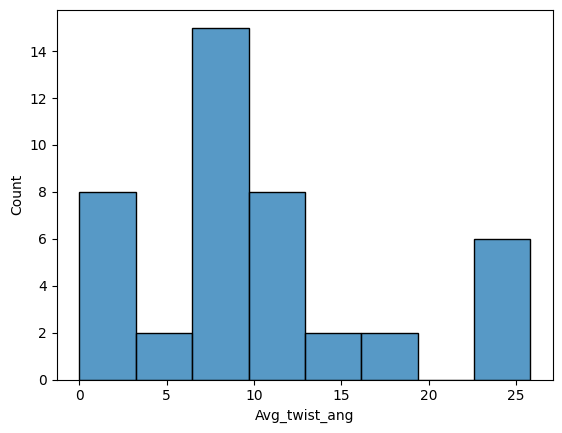

In [56]:
# @title Explore target value ('Avg_twist_ang') distribution

sns.histplot(data=df,x=df['Avg_twist_ang'])


In [57]:
# @title Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [58]:
# @title Data pre-processing
X_i, Y_org, X_org, Y_true = initialize_tensors(df)
X_i = X_i.to(device)
Y_org = Y_org.to(device)
X_org = X_org.to(device)
Y_true = Y_true.to(device)
bounds = torch.tensor([[500, 1.0, 1.0], [3500, 1.05, 1.05]],
                      dtype=torch.float64).to(device)
X_init, Y_init = initialize_samples(X_i, Y_org, num_samples=20)


In [59]:
# @title Run BO_AL
set_random_seed(42)
desired_value = 8.5

# Run Bayesian Optimization with the original format of data
results_df, cand_dict = bayesian_optimization(n_iterations=50, X_sample=X_init,\
                                       Y_sample=Y_init, X_i=X_i, Y_org=Y_org,\
                                       bounds=bounds, desired_target=desired_value)
results_df.to_csv('optimization_results.csv', index=False)

best_idx = torch.argmin(torch.abs(Y_init - torch.tensor(desired_value,
                                                            dtype=torch.float64)))
print("Optimization finished.")
print(f"Best location: {X_init[best_idx].cpu().numpy()}")
print(f"Best value: {Y_init[best_idx].cpu().numpy()}")

Acquisition Function: qExpectedImprovement
Kernel: MaternKernel


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([8.6287], dtype=torch.float64), mean = tensor([11.9640], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 1: Candidates = tensor([[7.2038e+02, 1.0089e+00, 1.0211e+00],
        [2.8149e+03, 1.0000e+00, 1.0291e+00],
        [1.5000e+03, 1.0099e+00, 1.0208e+00],
        [2.7985e+03, 1.0500e+00, 1.0333e+00],
        [1.1347e+03, 1.0097e+00, 1.0249e+00]], dtype=torch.float64),             Y_next = [11.70413119 12.08218009 13.17665327 11.78168752 13.18495738], MSE = 117.57505447047724, Uncertainty = 52.261220391408294



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6853], dtype=torch.float64), mean = tensor([12.0484], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 2: Candidates = tensor([[1.0798e+03, 1.0383e+00, 1.0052e+00],
        [1.5000e+03, 1.0100e+00, 1.0203e+00],
        [2.1192e+03, 1.0431e+00, 1.0296e+00],
        [5.9745e+02, 1.0111e+00, 1.0320e+00],
        [2.6492e+03, 1.0213e+00, 1.0170e+00]], dtype=torch.float64),             Y_next = [13.0588414  11.61642206 12.40765104 12.23873617 12.44181422], MSE = 40.92519343080644, Uncertainty = 44.438057289494935



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([6.9951], dtype=torch.float64), mean = tensor([12.0991], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 3: Candidates = tensor([[1.0117e+03, 1.0138e+00, 1.0042e+00],
        [1.5000e+03, 1.0097e+00, 1.0204e+00],
        [2.5114e+03, 1.0500e+00, 1.0000e+00],
        [3.4532e+03, 1.0288e+00, 1.0263e+00],
        [3.2964e+03, 1.0419e+00, 1.0073e+00]], dtype=torch.float64),             Y_next = [13.81471316 12.6214072  11.77903514 10.93801586 14.42908256], MSE = 129.37647121816363, Uncertainty = 38.22319834850302



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([6.4826], dtype=torch.float64), mean = tensor([12.1873], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 4: Candidates = tensor([[2.1029e+03, 1.0107e+00, 1.0414e+00],
        [1.5000e+03, 1.0098e+00, 1.0202e+00],
        [8.5115e+02, 1.0438e+00, 1.0439e+00],
        [2.7516e+03, 1.0065e+00, 1.0231e+00],
        [3.4616e+03, 1.0435e+00, 1.0339e+00]], dtype=torch.float64),             Y_next = [13.68087147  9.67189109 11.25871405 11.55412284 11.05984458], MSE = 71.16675599055695, Uncertainty = 33.48682787149134



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([6.0755], dtype=torch.float64), mean = tensor([12.0945], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 5: Candidates = tensor([[3.1325e+03, 1.0149e+00, 1.0136e+00],
        [2.0397e+03, 1.0272e+00, 1.0498e+00],
        [1.5000e+03, 1.0099e+00, 1.0203e+00],
        [1.3427e+03, 1.0450e+00, 1.0474e+00],
        [3.3294e+03, 1.0253e+00, 1.0101e+00]], dtype=torch.float64),             Y_next = [13.69629346 12.35222886 12.38519775 11.40976532 10.56641451], MSE = 51.09398232986089, Uncertainty = 29.69561447436489



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([5.7309], dtype=torch.float64), mean = tensor([12.0931], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 6: Candidates = tensor([[5.1661e+02, 1.0367e+00, 1.0144e+00],
        [1.7625e+03, 1.0128e+00, 1.0068e+00],
        [2.6889e+03, 1.0332e+00, 1.0378e+00],
        [1.6979e+03, 1.0239e+00, 1.0078e+00],
        [1.5000e+03, 1.0099e+00, 1.0202e+00]], dtype=torch.float64),             Y_next = [13.57989283 13.26239089 13.25953766 11.20306404 10.47454811], MSE = 132.6378722883484, Uncertainty = 26.532462502438356



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([5.4462], dtype=torch.float64), mean = tensor([12.1194], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 7: Candidates = tensor([[2.8946e+03, 1.0247e+00, 1.0350e+00],
        [3.2964e+03, 1.0419e+00, 1.0073e+00],
        [9.5592e+02, 1.0274e+00, 1.0105e+00],
        [2.2124e+03, 1.0096e+00, 1.0310e+00],
        [2.1569e+03, 1.0268e+00, 1.0341e+00]], dtype=torch.float64),             Y_next = [12.02169003 11.72680551 12.86453242 10.97202996 11.30962861], MSE = 32.56449944416804, Uncertainty = 24.024932682892583



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([5.1927], dtype=torch.float64), mean = tensor([12.0884], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 8: Candidates = tensor([[1.7846e+03, 1.0330e+00, 1.0318e+00],
        [8.6011e+02, 1.0085e+00, 1.0433e+00],
        [3.4113e+03, 1.0451e+00, 1.0353e+00],
        [1.5000e+03, 1.0097e+00, 1.0201e+00],
        [6.3405e+02, 1.0393e+00, 1.0299e+00]], dtype=torch.float64),             Y_next = [13.8160948  11.61490235 12.02863075 11.7971385  11.63984758], MSE = 48.552639212502136, Uncertainty = 21.87194816991708



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.9737], dtype=torch.float64), mean = tensor([12.0960], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 9: Candidates = tensor([[9.8238e+02, 1.0264e+00, 1.0057e+00],
        [1.7423e+03, 1.0500e+00, 1.0500e+00],
        [3.1131e+03, 1.0003e+00, 1.0236e+00],
        [1.5000e+03, 1.0097e+00, 1.0201e+00],
        [2.9284e+03, 1.0340e+00, 1.0175e+00]], dtype=torch.float64),             Y_next = [14.70044503 12.71180043 12.07203098 11.26296406 12.73953367], MSE = 32.77183360936827, Uncertainty = 20.016016150750044



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.7888], dtype=torch.float64), mean = tensor([12.1423], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 10: Candidates = tensor([[2.9419e+03, 1.0169e+00, 1.0012e+00],
        [2.2634e+03, 1.0338e+00, 1.0316e+00],
        [1.5000e+03, 1.0096e+00, 1.0201e+00],
        [1.9907e+03, 1.0300e+00, 1.0083e+00],
        [1.3897e+03, 1.0102e+00, 1.0136e+00]], dtype=torch.float64),             Y_next = [13.55432032 12.06156865 11.66107487 10.58235347 10.52082913], MSE = 81.1834714799284, Uncertainty = 18.449859803235228



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.6233], dtype=torch.float64), mean = tensor([12.1090], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 11: Candidates = tensor([[2.7882e+03, 1.0449e+00, 1.0239e+00],
        [1.5000e+03, 1.0095e+00, 1.0200e+00],
        [6.3963e+02, 1.0056e+00, 1.0500e+00],
        [1.8178e+03, 1.0295e+00, 1.0023e+00],
        [2.9816e+03, 1.0399e+00, 1.0469e+00]], dtype=torch.float64),             Y_next = [14.11004423 12.57647407 12.0798771  13.09242975 11.64264997], MSE = 35.10331427843637, Uncertainty = 17.15988640267317



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.4724], dtype=torch.float64), mean = tensor([12.1484], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 12: Candidates = tensor([[1.2402e+03, 1.0121e+00, 1.0195e+00],
        [1.0742e+03, 1.0417e+00, 1.0474e+00],
        [1.5000e+03, 1.0095e+00, 1.0200e+00],
        [3.1777e+03, 1.0022e+00, 1.0474e+00],
        [2.5894e+03, 1.0246e+00, 1.0012e+00]], dtype=torch.float64),             Y_next = [14.23955941 12.33967339 11.80476418 12.54436851 12.9676947 ], MSE = 95.36105063534553, Uncertainty = 16.0233032952987



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.3362], dtype=torch.float64), mean = tensor([12.1878], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 13: Candidates = tensor([[8.2378e+02, 1.0110e+00, 1.0375e+00],
        [1.2808e+03, 1.0095e+00, 1.0112e+00],
        [1.5000e+03, 1.0093e+00, 1.0201e+00],
        [1.3352e+03, 1.0027e+00, 1.0357e+00],
        [2.9795e+03, 1.0437e+00, 1.0486e+00]], dtype=torch.float64),             Y_next = [14.72734522 13.24863291 12.46014054 13.18038134 11.18055773], MSE = 109.63730446401796, Uncertainty = 15.02449807234144



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.2186], dtype=torch.float64), mean = tensor([12.2332], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 14: Candidates = tensor([[2.6753e+03, 1.0000e+00, 1.0000e+00],
        [6.8329e+02, 1.0500e+00, 1.0000e+00],
        [2.6243e+03, 1.0500e+00, 1.0500e+00],
        [7.9634e+02, 1.0000e+00, 1.0399e+00],
        [1.5000e+03, 1.0097e+00, 1.0204e+00]], dtype=torch.float64),             Y_next = [14.41522944 10.60574463 11.71021651 10.10179712 11.05256258], MSE = 61.55506589596784, Uncertainty = 14.141494577797728



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.1168], dtype=torch.float64), mean = tensor([12.1968], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 15: Candidates = tensor([[2.4095e+03, 1.0500e+00, 1.0000e+00],
        [7.6043e+02, 1.0500e+00, 1.0500e+00],
        [1.5049e+03, 1.0141e+00, 1.0279e+00],
        [5.6837e+02, 1.0000e+00, 1.0000e+00],
        [1.4949e+03, 1.0042e+00, 1.0121e+00]], dtype=torch.float64),             Y_next = [14.09932197 13.72587032 13.2733489  13.048124   12.25365456], MSE = 71.2190639989893, Uncertainty = 13.38910432459978



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.0158], dtype=torch.float64), mean = tensor([12.2538], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 16: Candidates = tensor([[1.0426e+03, 1.0500e+00, 1.0300e+00],
        [7.6869e+02, 1.0000e+00, 1.0000e+00],
        [2.3635e+03, 1.0334e+00, 1.0500e+00],
        [1.5001e+03, 1.0094e+00, 1.0196e+00],
        [1.6244e+03, 1.0198e+00, 1.0008e+00]], dtype=torch.float64),             Y_next = [15.20313555 13.70350702 10.88586982 11.48802242 10.74115831], MSE = 70.21028614207067, Uncertainty = 12.735576738689366



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.9331], dtype=torch.float64), mean = tensor([12.2613], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 17: Candidates = tensor([[1.4998e+03, 1.0000e+00, 1.0000e+00],
        [1.4918e+03, 1.0500e+00, 1.0500e+00],
        [1.8406e+03, 1.0000e+00, 1.0500e+00],
        [3.0044e+03, 1.0269e+00, 1.0473e+00],
        [1.5078e+03, 1.0500e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [15.47954817 15.20318804 15.09050883 11.90236566 13.146362  ], MSE = 59.86546439225581, Uncertainty = 12.122172529252891



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.8712], dtype=torch.float64), mean = tensor([12.3519], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 18: Candidates = tensor([[1.7282e+03, 1.0000e+00, 1.0500e+00],
        [1.5058e+03, 1.0196e+00, 1.0000e+00],
        [1.0095e+03, 1.0000e+00, 1.0500e+00],
        [1.1122e+03, 1.0000e+00, 1.0000e+00],
        [1.4945e+03, 1.0008e+00, 1.0408e+00]], dtype=torch.float64),             Y_next = [14.45380915 14.49528661 11.53351332 12.33018168 10.33427951], MSE = 169.06368361594818, Uncertainty = 11.50992198148386



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.7979], dtype=torch.float64), mean = tensor([12.3645], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 19: Candidates = tensor([[2.2464e+03, 1.0500e+00, 1.0000e+00],
        [2.4307e+03, 1.0055e+00, 1.0500e+00],
        [1.5055e+03, 1.0220e+00, 1.0231e+00],
        [1.3086e+03, 1.0500e+00, 1.0500e+00],
        [1.4945e+03, 1.0000e+00, 1.0119e+00]], dtype=torch.float64),             Y_next = [13.9788397  14.45842737 12.54795661 10.92830515 11.75936305], MSE = 85.70860116195472, Uncertainty = 10.992053624829827



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.7248], dtype=torch.float64), mean = tensor([12.3806], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 20: Candidates = tensor([[2.8452e+03, 1.0418e+00, 1.0126e+00],
        [1.5000e+03, 1.0096e+00, 1.0207e+00],
        [7.7275e+02, 1.0000e+00, 1.0000e+00],
        [3.0489e+03, 1.0001e+00, 1.0500e+00],
        [2.3098e+03, 1.0500e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [15.87011603 11.25940735 11.74850012 10.49083947 11.86069132], MSE = 54.03972540258597, Uncertainty = 10.531554048598078



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.6661], dtype=torch.float64), mean = tensor([12.3750], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 21: Candidates = tensor([[1.9249e+03, 1.0000e+00, 1.0500e+00],
        [1.5000e+03, 1.0093e+00, 1.0194e+00],
        [3.4008e+03, 1.0000e+00, 1.0000e+00],
        [3.3607e+03, 1.0000e+00, 1.0000e+00],
        [7.4437e+02, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [15.78670273 12.58390263 11.8091662  11.97324173 10.49446579], MSE = 58.08936576234449, Uncertainty = 10.110590902713676



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.6090], dtype=torch.float64), mean = tensor([12.3812], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 22: Candidates = tensor([[1.6584e+03, 1.0500e+00, 1.0480e+00],
        [1.5000e+03, 1.0099e+00, 1.0216e+00],
        [3.2703e+03, 1.0496e+00, 1.0274e+00],
        [1.0983e+03, 1.0500e+00, 1.0500e+00],
        [2.8247e+03, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [14.65801775  9.22946906 13.55075419  9.79078928 13.23086357], MSE = 62.617860658010315, Uncertainty = 9.716652366972852



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5644], dtype=torch.float64), mean = tensor([12.3701], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 23: Candidates = tensor([[1.0298e+03, 1.0500e+00, 1.0111e+00],
        [1.5000e+03, 1.0109e+00, 1.0201e+00],
        [2.8874e+03, 1.0000e+00, 1.0000e+00],
        [2.3834e+03, 1.0500e+00, 1.0000e+00],
        [2.7782e+03, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [13.94193413 11.56739979 11.07239042 12.04541742 11.93090997], MSE = 93.17588234769013, Uncertainty = 9.472265346923471



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5027], dtype=torch.float64), mean = tensor([12.3605], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 24: Candidates = tensor([[1.5000e+03, 1.0100e+00, 1.0202e+00],
        [1.9514e+03, 1.0500e+00, 1.0000e+00],
        [2.8090e+03, 1.0500e+00, 1.0000e+00],
        [7.2815e+02, 1.0500e+00, 1.0500e+00],
        [1.1951e+03, 1.0500e+00, 1.0240e+00]], dtype=torch.float64),             Y_next = [14.78300551 12.13199076 11.78269188 10.68387769 13.35743573], MSE = 41.629073818270726, Uncertainty = 9.14101775460579



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4496], dtype=torch.float64), mean = tensor([12.3672], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 25: Candidates = tensor([[1.0775e+03, 1.0199e+00, 1.0377e+00],
        [5.6312e+02, 1.0500e+00, 1.0217e+00],
        [1.5000e+03, 1.0103e+00, 1.0200e+00],
        [1.8834e+03, 1.0372e+00, 1.0000e+00],
        [2.1655e+03, 1.0000e+00, 1.0458e+00]], dtype=torch.float64),             Y_next = [14.8509182  12.81935319 12.11596736 10.87720637 13.2316855 ], MSE = 98.30591445110758, Uncertainty = 8.844634000490027



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3988], dtype=torch.float64), mean = tensor([12.3814], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 26: Candidates = tensor([[1.7311e+03, 1.0360e+00, 1.0197e+00],
        [1.3129e+03, 1.0386e+00, 1.0283e+00],
        [2.3973e+03, 1.0234e+00, 1.0420e+00],
        [2.5576e+03, 1.0500e+00, 1.0000e+00],
        [1.5000e+03, 1.0088e+00, 1.0213e+00]], dtype=torch.float64),             Y_next = [16.03031321 12.50292444 11.93762454 11.9197896  11.20346694], MSE = 31.27126436525014, Uncertainty = 8.566336164051345



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3564], dtype=torch.float64), mean = tensor([12.3926], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 27: Candidates = tensor([[5.8637e+02, 1.0276e+00, 1.0000e+00],
        [9.1488e+02, 1.0000e+00, 1.0084e+00],
        [2.0018e+03, 1.0204e+00, 1.0028e+00],
        [1.4950e+03, 1.0218e+00, 1.0000e+00],
        [1.5051e+03, 1.0000e+00, 1.0464e+00]], dtype=torch.float64),             Y_next = [15.130541   14.69841572 11.87602592 10.31312946 12.25904977], MSE = 54.73378980824292, Uncertainty = 8.281169705431042



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3185], dtype=torch.float64), mean = tensor([12.4076], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 28: Candidates = tensor([[2.8109e+03, 1.0429e+00, 1.0420e+00],
        [8.1129e+02, 1.0500e+00, 1.0000e+00],
        [2.2706e+03, 1.0479e+00, 1.0321e+00],
        [1.4999e+03, 1.0093e+00, 1.0185e+00],
        [1.7419e+03, 1.0156e+00, 1.0480e+00]], dtype=torch.float64),             Y_next = [14.65461711 11.70958792 11.024933   12.60329628 12.27720326], MSE = 81.79712495603059, Uncertainty = 8.02426253966474



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2732], dtype=torch.float64), mean = tensor([12.4090], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 29: Candidates = tensor([[1.4949e+03, 1.0209e+00, 1.0324e+00],
        [1.5049e+03, 1.0000e+00, 1.0078e+00],
        [2.2224e+03, 1.0061e+00, 1.0432e+00],
        [2.4432e+03, 1.0394e+00, 1.0440e+00],
        [2.9912e+03, 1.0265e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [14.99463664 14.59159259 10.92199653 11.46769361 12.35684638], MSE = 76.94374775972007, Uncertainty = 7.781223256225907



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2366], dtype=torch.float64), mean = tensor([12.4229], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 30: Candidates = tensor([[3.2155e+03, 1.0125e+00, 1.0349e+00],
        [1.4948e+03, 1.0046e+00, 1.0433e+00],
        [1.5050e+03, 1.0126e+00, 1.0000e+00],
        [1.6609e+03, 1.0000e+00, 1.0000e+00],
        [2.9564e+03, 1.0500e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [15.09479172 14.93230583 10.2195144  10.61838342 12.61876669], MSE = 80.21477329162126, Uncertainty = 7.555363627889908



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2083], dtype=torch.float64), mean = tensor([12.4309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 31: Candidates = tensor([[3.1874e+03, 1.0276e+00, 1.0384e+00],
        [1.5000e+03, 1.0092e+00, 1.0185e+00],
        [1.0647e+03, 1.0461e+00, 1.0128e+00],
        [9.6770e+02, 1.0000e+00, 1.0356e+00],
        [2.2050e+03, 1.0028e+00, 1.0426e+00]], dtype=torch.float64),             Y_next = [14.93071327 11.57233207 11.58796693 11.92289252 10.2996373 ], MSE = 47.81538122118188, Uncertainty = 7.362165111461114



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1732], dtype=torch.float64), mean = tensor([12.4204], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 32: Candidates = tensor([[2.7187e+03, 1.0448e+00, 1.0230e+00],
        [1.4952e+03, 1.0207e+00, 1.0000e+00],
        [2.7146e+03, 1.0285e+00, 1.0128e+00],
        [1.5052e+03, 1.0000e+00, 1.0435e+00],
        [1.7100e+03, 1.0150e+00, 1.0059e+00]], dtype=torch.float64),             Y_next = [15.14502061 15.18218799 12.88793908 12.70357302 11.66864004], MSE = 91.69398002951307, Uncertainty = 7.1571268263550625



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1426], dtype=torch.float64), mean = tensor([12.4509], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 33: Candidates = tensor([[3.2011e+03, 1.0191e+00, 1.0000e+00],
        [1.8316e+03, 1.0500e+00, 1.0500e+00],
        [1.4948e+03, 1.0225e+00, 1.0000e+00],
        [1.5050e+03, 1.0000e+00, 1.0404e+00],
        [7.5818e+02, 1.0023e+00, 1.0030e+00]], dtype=torch.float64),             Y_next = [15.33115821 15.70040678 12.43622061 10.28945253 11.42541467], MSE = 43.49508497767725, Uncertainty = 6.962792214514561



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1210], dtype=torch.float64), mean = tensor([12.4667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 34: Candidates = tensor([[1.5000e+03, 1.0092e+00, 1.0192e+00],
        [3.4494e+03, 1.0150e+00, 1.0092e+00],
        [5.1696e+02, 1.0500e+00, 1.0111e+00],
        [1.8008e+03, 1.0497e+00, 1.0270e+00],
        [2.9754e+03, 1.0261e+00, 1.0195e+00]], dtype=torch.float64),             Y_next = [14.9554624  12.42249296 13.11111838 11.37265691 10.60773838], MSE = 42.363206379901655, Uncertainty = 6.7865113211135775



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0891], dtype=torch.float64), mean = tensor([12.4674], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 35: Candidates = tensor([[1.5061e+03, 1.0208e+00, 1.0000e+00],
        [5.6848e+02, 1.0109e+00, 1.0357e+00],
        [1.4940e+03, 1.0000e+00, 1.0398e+00],
        [1.6569e+03, 1.0012e+00, 1.0446e+00],
        [1.3219e+03, 1.0464e+00, 1.0467e+00]], dtype=torch.float64),             Y_next = [14.95743292 15.10449786 13.28166546 12.89486604 13.45788945], MSE = 78.35762663297035, Uncertainty = 6.601744126289546



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0615], dtype=torch.float64), mean = tensor([12.5052], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 36: Candidates = tensor([[2.9069e+03, 1.0086e+00, 1.0272e+00],
        [1.3789e+03, 1.0349e+00, 1.0414e+00],
        [1.4938e+03, 1.0000e+00, 1.0481e+00],
        [2.7187e+03, 1.0048e+00, 1.0180e+00],
        [1.5058e+03, 1.0188e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [15.05001572 15.27657254 11.00990403 12.32897081 11.55632499], MSE = 70.23449031905724, Uncertainty = 6.444096588984562



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0371], dtype=torch.float64), mean = tensor([12.5186], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 37: Candidates = tensor([[1.7693e+03, 1.0490e+00, 1.0000e+00],
        [1.5064e+03, 1.0176e+00, 1.0480e+00],
        [2.0574e+03, 1.0239e+00, 1.0359e+00],
        [1.2582e+03, 1.0481e+00, 1.0145e+00],
        [1.4943e+03, 1.0000e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [15.061065   14.81136107 12.07493873 12.25255101 12.34192281], MSE = 49.22560262479759, Uncertainty = 6.282636186916008



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0094], dtype=torch.float64), mean = tensor([12.5379], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 38: Candidates = tensor([[1.7765e+03, 1.0247e+00, 1.0033e+00],
        [1.5060e+03, 1.0000e+00, 1.0438e+00],
        [2.5909e+03, 1.0481e+00, 1.0479e+00],
        [1.4939e+03, 1.0248e+00, 1.0000e+00],
        [2.9757e+03, 1.0187e+00, 1.0297e+00]], dtype=torch.float64),             Y_next = [14.76883048 14.65464324 13.01093044 12.67236728 12.72873956], MSE = 90.02486012066115, Uncertainty = 6.1270174423336385



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9809], dtype=torch.float64), mean = tensor([12.5624], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 39: Candidates = tensor([[1.4999e+03, 1.0084e+00, 1.0171e+00],
        [8.9232e+02, 1.0188e+00, 1.0075e+00],
        [2.8857e+03, 1.0052e+00, 1.0455e+00],
        [1.2763e+03, 1.0228e+00, 1.0404e+00],
        [1.7339e+03, 1.0110e+00, 1.0076e+00]], dtype=torch.float64),             Y_next = [15.56825845 10.25349481 10.69551382 12.17801748 10.8678048 ], MSE = 129.67824177191824, Uncertainty = 5.99224417409569



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9623], dtype=torch.float64), mean = tensor([12.5473], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 40: Candidates = tensor([[2.9573e+03, 1.0336e+00, 1.0050e+00],
        [1.4996e+03, 1.0500e+00, 1.0000e+00],
        [1.4896e+03, 1.0000e+00, 1.0500e+00],
        [1.5095e+03, 1.0000e+00, 1.0500e+00],
        [2.6955e+03, 1.0257e+00, 1.0067e+00]], dtype=torch.float64),             Y_next = [14.98838781 14.55012557 15.06838512 11.72690872 10.34094209], MSE = 48.63060412131841, Uncertainty = 5.866300189151178



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9453], dtype=torch.float64), mean = tensor([12.5652], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 41: Candidates = tensor([[1.4936e+03, 1.0158e+00, 1.0479e+00],
        [2.6887e+03, 1.0406e+00, 1.0116e+00],
        [1.5056e+03, 1.0004e+00, 1.0000e+00],
        [3.1424e+03, 1.0323e+00, 1.0003e+00],
        [2.2374e+03, 1.0421e+00, 1.0232e+00]], dtype=torch.float64),             Y_next = [15.20058644 15.09373855 11.87793656 11.62424486 11.3839584 ], MSE = 68.86206496478702, Uncertainty = 5.7382752453539805



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9245], dtype=torch.float64), mean = tensor([12.5757], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 42: Candidates = tensor([[9.1834e+02, 1.0004e+00, 1.0258e+00],
        [2.0032e+03, 1.0308e+00, 1.0222e+00],
        [2.3575e+03, 1.0178e+00, 1.0433e+00],
        [1.4997e+03, 1.0069e+00, 1.0182e+00],
        [5.0353e+02, 1.0206e+00, 1.0396e+00]], dtype=torch.float64),             Y_next = [15.34208429 11.0723025  12.54926586 12.82500068 11.56213211], MSE = 26.382748454923217, Uncertainty = 5.60688534779691



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9007], dtype=torch.float64), mean = tensor([12.5777], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 43: Candidates = tensor([[1.8565e+03, 1.0104e+00, 1.0288e+00],
        [2.1083e+03, 1.0379e+00, 1.0169e+00],
        [6.0443e+02, 1.0000e+00, 1.0500e+00],
        [3.1515e+03, 1.0045e+00, 1.0154e+00],
        [1.4997e+03, 1.0095e+00, 1.0164e+00]], dtype=torch.float64),             Y_next = [15.07133771 11.95845762 11.96683828 12.15320463 12.00285742], MSE = 64.448184583688, Uncertainty = 5.499611886568952



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.8751], dtype=torch.float64), mean = tensor([12.5788], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 44: Candidates = tensor([[2.7681e+03, 1.0021e+00, 1.0495e+00],
        [1.4997e+03, 1.0056e+00, 1.0171e+00],
        [3.3516e+03, 1.0338e+00, 1.0478e+00],
        [1.9605e+03, 1.0466e+00, 1.0303e+00],
        [1.6298e+03, 1.0094e+00, 1.0476e+00]], dtype=torch.float64),             Y_next = [14.93142127 11.77453724 13.72590562 10.52080142 11.87405579], MSE = 87.38729212242413, Uncertainty = 5.382532228130709



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.8538], dtype=torch.float64), mean = tensor([12.5786], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 45: Candidates = tensor([[1.3218e+03, 1.0500e+00, 1.0007e+00],
        [2.8875e+03, 1.0500e+00, 1.0062e+00],
        [1.9270e+03, 1.0304e+00, 1.0011e+00],
        [1.1493e+03, 1.0040e+00, 1.0046e+00],
        [1.4997e+03, 1.0079e+00, 1.0163e+00]], dtype=torch.float64),             Y_next = [14.94714906 10.49390637 12.43024263 11.96816493 11.33612393], MSE = 73.37198443579832, Uncertainty = 5.287252413516731



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.8331], dtype=torch.float64), mean = tensor([12.5716], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 46: Candidates = tensor([[2.8738e+03, 1.0500e+00, 1.0441e+00],
        [2.4152e+03, 1.0378e+00, 1.0383e+00],
        [1.4997e+03, 1.0079e+00, 1.0172e+00],
        [9.8898e+02, 1.0007e+00, 1.0017e+00],
        [3.0958e+03, 1.0096e+00, 1.0200e+00]], dtype=torch.float64),             Y_next = [15.12892531 12.26620549 10.51996187 12.20272623 11.79073109], MSE = 29.455725004715998, Uncertainty = 5.188941524864329



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.8128], dtype=torch.float64), mean = tensor([12.5678], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 47: Candidates = tensor([[3.4136e+03, 1.0102e+00, 1.0001e+00],
        [1.2230e+03, 1.0004e+00, 1.0277e+00],
        [1.4931e+03, 1.0193e+00, 1.0396e+00],
        [1.5069e+03, 1.0000e+00, 1.0000e+00],
        [2.2020e+03, 1.0000e+00, 1.0373e+00]], dtype=torch.float64),             Y_next = [15.06034066 15.26707879 11.91766636 11.10167616 12.24930046], MSE = 111.6793435478334, Uncertainty = 5.082084785678421



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.7963], dtype=torch.float64), mean = tensor([12.5786], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 48: Candidates = tensor([[2.4961e+03, 1.0216e+00, 1.0103e+00],
        [1.0780e+03, 1.0149e+00, 1.0000e+00],
        [1.4998e+03, 1.0073e+00, 1.0162e+00],
        [3.0698e+03, 1.0469e+00, 1.0045e+00],
        [1.9694e+03, 1.0225e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [15.0380328  11.32684776 11.7925462  10.55480332 11.16731124], MSE = 114.3757003542599, Uncertainty = 4.983931981257257



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.7791], dtype=torch.float64), mean = tensor([12.5670], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 49: Candidates = tensor([[2.2307e+03, 1.0092e+00, 1.0278e+00],
        [1.9489e+03, 1.0411e+00, 1.0487e+00],
        [3.4118e+03, 1.0002e+00, 1.0480e+00],
        [1.4999e+03, 1.0102e+00, 1.0146e+00],
        [1.2035e+03, 1.0279e+00, 1.0488e+00]], dtype=torch.float64),             Y_next = [15.1626679  11.19298287 12.55070825 11.58167796 11.30091489], MSE = 50.49218409314919, Uncertainty = 4.8797005845751205



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.7604], dtype=torch.float64), mean = tensor([12.5630], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 50: Candidates = tensor([[1.4923e+03, 1.0000e+00, 1.0000e+00],
        [2.8522e+03, 1.0380e+00, 1.0081e+00],
        [8.2837e+02, 1.0127e+00, 1.0477e+00],
        [1.5082e+03, 1.0202e+00, 1.0437e+00],
        [3.3072e+03, 1.0122e+00, 1.0149e+00]], dtype=torch.float64),             Y_next = [15.0523345  14.6513267  12.10552161 12.10016482 11.50505696], MSE = 53.87996802744059, Uncertainty = 4.787567674135673



<ipython-input-53-0b76c16e358a>:225: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Optimization finished.
Best location: [2.500e+03 1.035e+00 1.035e+00]
Best value: [8.43504433]


In [31]:
results_df

,Temperature_K,Strain,Shear_Strain,Objective_Value
0,1500.000000,1.000000,1.000000,25.465624
1,500.000000,1.000000,1.000000,12.641907
2,2500.000000,1.000000,1.000000,0.188142
3,2500.000000,1.015000,1.000000,8.608880
4,500.000000,1.015000,1.000000,8.932990
...,...,...,...,...
288,1492.316887,1.000000,1.000000,15.052334
289,1508.231291,1.020225,1.043674,14.651327
290,3307.207529,1.012247,1.014930,12.105522
291,828.374529,1.012718,1.047728,12.100165


<Axes: xlabel='Objective_Value', ylabel='Count'>

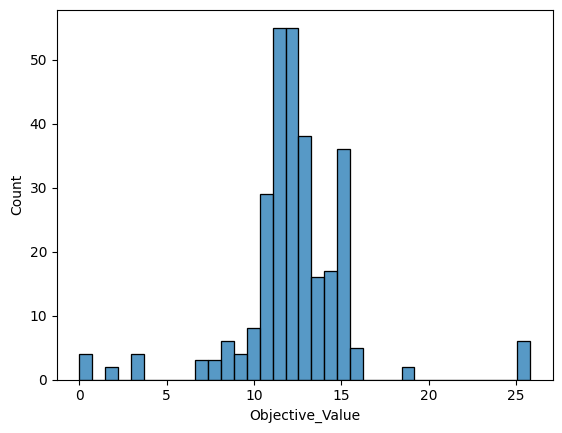

In [33]:
sns.histplot(data=results_df, x=results_df['Objective_Value'])

In [47]:
cand_dict

[{'Temp_K': 1499.9999735862339,
  'Strain': 1.0099249326067687,
  'Shear_Strain': 1.0208360121451505},
 {'Temp_K': 1134.6700275316834,
  'Strain': 1.0097043726593256,
  'Shear_Strain': 1.02489965823479},
 {'Temp_K': 2814.885376356317,
  'Strain': 1.0,
  'Shear_Strain': 1.0291223779100447},
 {'Temp_K': 720.382141880691,
  'Strain': 1.0088526483159512,
  'Shear_Strain': 1.0210966167971491},
 {'Temp_K': 2798.471297733711,
  'Strain': 1.05,
  'Shear_Strain': 1.0332537316937476},
 {'Temp_K': 1500.0000489770541,
  'Strain': 1.0100101073189125,
  'Shear_Strain': 1.020338767581244},
 {'Temp_K': 1079.7672457993008,
  'Strain': 1.0383414581883696,
  'Shear_Strain': 1.0052018948830663},
 {'Temp_K': 2119.20886300504,
  'Strain': 1.0430853745900093,
  'Shear_Strain': 1.0296294546686113},
 {'Temp_K': 2649.2021325975634,
  'Strain': 1.02132286936976,
  'Shear_Strain': 1.0170142272952944},
 {'Temp_K': 597.4452178925253,
  'Strain': 1.0111403664574026,
  'Shear_Strain': 1.0319997465237976},
 {'Temp_K':

In [50]:
# Convert the Objective_Value column to a PyTorch tensor
objective_values = torch.tensor(results_df.Objective_Value.values, dtype=torch.float64)

# Find the index of the minimum difference to the desired value
best_idx = torch.argmin(torch.abs(objective_values - torch.tensor(desired_value, dtype=torch.float64)))

print("Optimization finished.")

# Access the best location and value from the DataFrame
best_location = results_df.iloc[best_idx.item(), 0:3].values
best_value = results_df.iloc[best_idx.item()].Objective_Value

print(f"Best location: {best_location}")
print(f"Best value: {best_value}")

Optimization finished.
Best location: [2.500e+03 1.035e+00 1.000e+00]
Best value: 8.43504432590883
